# Chapter 6: Portfolio Basics
This notebook is divided in four sections. Section 1 presents some fundamental concepts such as stock prices, rate of retunns and net asset value. In section 2 are presented some performance measures such as expected return, volatility, the Sharpe ratio. In section 3 is presented a technique to test an investment strategy using historical data called backtesting. In section 4 are presented some heuristic portfolios that are based on investment strategies that have been found to be successful.

In [32]:
# Core numerical computing
import numpy as np
import pandas as pd

# For financial data
import yfinance as yf       # Lodaing financial data
import empyrical as emp     # Performance metrics

# Book data (pip install "git+https://github.com/dppalomar/pob.git#subdirectory=python")
from pob_python import SP500_stocks_2015to2020, SP500_index_2015to2020

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(style="darkgrid")

# Optimization
import cvxpy as cp       # interface for convex optimization solvers
#import riskparityportfolio as rpp # installation fails
from scipy.optimize import minimize, LinearConstraint   # for optimization
import warnings
warnings.filterwarnings('ignore')
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Seaborn version: {}'.format(sns.__version__))
print('YFinance version: {}'.format(yf.__version__))

NumPy version: 1.26.4
Pandas version: 2.2.2
Seaborn version: 0.13.2
YFinance version: 0.2.65


## 1. Fundamentals
This section starts by downloading a typical financial dataset and presents some fundamental concepts: stock prices, rate of returns, expected return, net asset value

### Financial datasets
It is not easy to get financial time series for free. One financial data source is [Yahoo Finance](https://finance.yahoo.com/quote/NVDA/history/) that can be consumed parsing the source page in Google Chrome copying the HTML data of the container div element, or more easily through the YFinance Python package. Another data source is [Nasdaq](https://www.nasdaq.com/market-activity/stocks/nvda/historical).

In [35]:
stocks = yf.download(["AAPL", "AMD", "ADI", "A", "MOH", "CVS", "APD", "AA", "CF"], start='2021-10-01', end='2021-12-31')

[*********************100%***********************]  9 of 9 completed


In [36]:
stocks.head()

Price            Close                                                 \
Ticker               A         AA        AAPL         ADI         AMD   
Date                                                                    
2021-10-01  151.454758  47.667320  139.650635  155.883759  102.449997   
2021-10-04  148.114517  47.102242  136.214432  152.987198  100.339996   
2021-10-05  148.765839  46.977749  138.143066  154.021042  101.809998   
2021-10-06  149.368561  45.062233  139.014313  154.654358  103.639999   
2021-10-07  150.992035  45.062233  140.277206  155.520538  106.449997   

Price                                                           High  ...  \
Ticker             APD         CF        CVS         MOH           A  ...   
Date                                                                  ...   
2021-10-01  232.851028  56.194256  73.482239  271.510010  152.920851  ...   
2021-10-04  231.548508  55.826614  73.254974  269.500000  151.944732  ...   
2021-10-05  232.480148  55.541702  73.106369  269.410004  151.439210  ...   
2021-10-06  235.854034  55.008598  72.678101  270.510010  149.961564  ...   
2021-10-07  238.205795  55.753082  73.595840  277.119995  153.091836  ...   

Price             Open   Volume                                        \
Ticker             MOH        A       AA      AAPL      ADI       AMD   
Date                                                                    
2021-10-01  271.209991  1881900  6561200  94639600  3549200  41491600   
2021-10-04  269.359985  1758300  4681700  98322000  5377500  41967100   
2021-10-05  272.079987  1494300  4226400  80861100  2899100  31455200   
2021-10-06  266.980011  1794700  7321800  83221100  2754000  39071700   
2021-10-07  273.700012  1002800  5916600  61732700  2174100  41543100   

Price                                          
Ticker          APD       CF      CVS     MOH  
Date                                           
2021-10-01   877000  7615500  6888400  260700  
2021-10-04  1007000  4170100  4768000  167700  
2021-10-05   970900  4236500  4848600  305600  
2021-10-06  1310200  4244200  5205100  197900  
2021-10-07  1359600  4388700  4262000  168200  

[5 rows x 45 columns]

In [37]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63 entries, 2021-10-01 to 2021-12-30
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, A)      63 non-null     float64
 1   (Close, AA)     63 non-null     float64
 2   (Close, AAPL)   63 non-null     float64
 3   (Close, ADI)    63 non-null     float64
 4   (Close, AMD)    63 non-null     float64
 5   (Close, APD)    63 non-null     float64
 6   (Close, CF)     63 non-null     float64
 7   (Close, CVS)    63 non-null     float64
 8   (Close, MOH)    63 non-null     float64
 9   (High, A)       63 non-null     float64
 10  (High, AA)      63 non-null     float64
 11  (High, AAPL)    63 non-null     float64
 12  (High, ADI)     63 non-null     float64
 13  (High, AMD)     63 non-null     float64
 14  (High, APD)     63 non-null     float64
 15  (High, CF)      63 non-null     float64
 16  (High, CVS)     63 non-null     float64
 17  (High, MOH)     6

In [38]:
stocks['Close'].head()

Ticker,A,AA,AAPL,ADI,AMD,APD,CF,CVS,MOH
Date,,,,,,,,,
2021-10-01,151.454758,47.667320,139.650635,155.883759,102.449997,232.851028,56.194256,73.482239,271.510010
2021-10-04,148.114517,47.102242,136.214432,152.987198,100.339996,231.548508,55.826614,73.254974,269.500000
2021-10-05,148.765839,46.977749,138.143066,154.021042,101.809998,232.480148,55.541702,73.106369,269.410004
2021-10-06,149.368561,45.062233,139.014313,154.654358,103.639999,235.854034,55.008598,72.678101,270.510010
2021-10-07,150.992035,45.062233,140.277206,155.520538,106.449997,238.205795,55.753082,73.595840,277.119995


For this notebook we will use the S&P500 index and the crypto currencies datasets from the book's Python package 

In [39]:
from pob_python import SP500_stocks_2015to2020, cryptos_2017to2021_hourly
# stock S&P500 market data
SP500_stocks_2015to2020.iloc[:, :5].head()

,A,AAL,AAP,AAPL,ABBV
Date,,,,,
2015-01-05,37.7523,51.0467,154.217,24.239,50.8722
2015-01-06,37.1642,50.2556,154.108,24.241,50.6204
2015-01-07,37.6574,50.2272,157.420,24.581,52.6663
2015-01-08,38.7862,50.8430,158.800,25.526,53.2171
2015-01-09,38.5016,49.2891,157.991,25.553,51.7614


In [40]:
# crypto data
cryptos_2017to2021_hourly.iloc[:, :5].head()

,BTC,ETH,ADA,DOT,XRP
Date,,,,,
2021-01-07 09:00:00,37485.61,1204.525106,0.330998,10.005659,0.305133
2021-01-07 10:00:00,37040.38,1183.403101,0.308546,9.677910,0.323733
2021-01-07 11:00:00,37806.57,1201.001309,0.311904,9.823281,0.357990
2021-01-07 12:00:00,37936.25,1227.161815,0.317906,9.966991,0.336457
2021-01-07 13:00:00,38154.69,1218.126633,0.318592,9.882065,0.328512


We plot the stock prices of some of the firms in the dataset

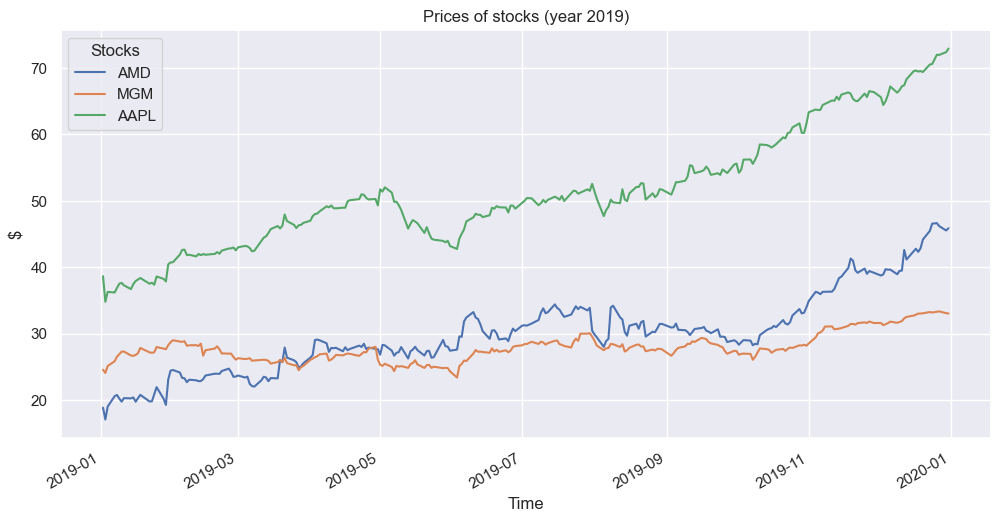

In [41]:
stock_prices_2019 = SP500_stocks_2015to2020[["AMD", "MGM", "AAPL"]].loc['2019-01-01':'2019-12-31']
fig, ax = plt.subplots(figsize=(12, 6))
stock_prices_2019.plot(ax=ax)
ax.set_title('Prices of stocks (year 2019)')
ax.set_xlabel('Time')
ax.set_ylabel('$')
ax.legend(title="Stocks")
plt.show()

### Linear returns
We use the DataFrame method [pct_change()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) to calculate the linear rate of return from the prices, defined as (see p.143)

$$r_t = \frac{p_t - p_{t-1}}{p_{t-1}}$$

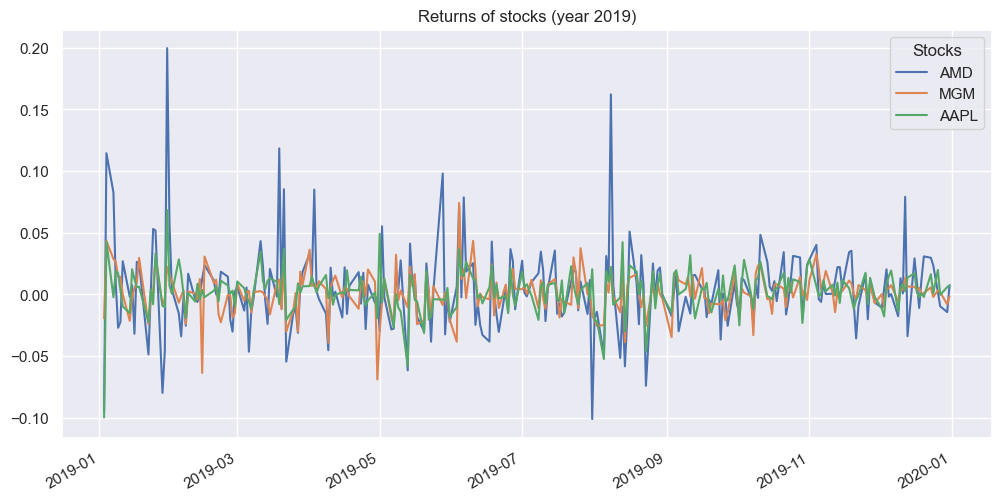

In [62]:
stock_returns_2019 = stock_prices_2019.pct_change().dropna()
# Plot returns
fig, ax = plt.subplots(figsize=(12, 6))
stock_returns_2019.plot(ax=ax)
ax.set_title('Returns of stocks (year 2019)')
ax.set_xlabel(None)
ax.legend(title="Stocks")
plt.show()

## 2. Performance Measures
In this section are presented some performance measures, aka risk factors, such as portfolio return, expected return, volatility, the Sharpe ratio. The portfolio return $R_t^{portf}$ is the returns of each security in the portfolio (see p.151, eq. 6.8)

$$R_t^{portf} = w^Tr_t$$

where $r_t$ is the matrix of the periodic (e.g. daily) returns of the stocks in the portfolio.

### Expected return
The expected return of a portfolio of p stocks over N periods, e.g. days, is defined, assuming independent and identically distributed random observations, as

$$E[R_t^{portf}] = w^T \mu$$

where 

$$\mu = \frac{1}{N} \sum_{t=1}^N r_{it}$$

and w is the vector of the weights of the stocks in the portfolio

In [43]:
num_trading_days_2019 = stock_returns_2019.shape[0]
num_trading_days_2019

252

In [44]:
mean_return_2019 = stock_returns_2019.mean()
mean_return_2019

AMD     0.004110
MGM     0.001318
AAPL    0.002671
dtype: float64

Let's say we have 10 shares of AMD, 10 of MGM, and 20 of AAPL

In [45]:
w = np.array([10, 10, 20])
w_norm = w / w.sum()
w_norm

array([0.25, 0.25, 0.5 ])

In [46]:
exp_return_2019 = np.dot(w_norm, mean_return_2019.to_numpy())
print('Expected portfolio return for 2019: {:.3f}'.format(exp_return_2019))

Expected portfolio return for 2019: 0.003


### Annualized return
The annualized return is the average daily return $\mu$ times the number of trading days $\gamma$ in a year 

$$A = \gamma w^T \mu $$

where w is the normalized vector of the weights for each asset in a portfolio (see p.156). 

In [47]:
return_2019 = num_trading_days_2019 * exp_return_2019
print('Annualized return for 2019: {:.2f} $'.format(return_2019))

Annualized return for 2019: 0.68 $


### Net Asset Value (NAV) 
It's fundamental to calculate the cumulative returns of the stocks, that is the change in value of the assets with time. It works like compounding for bonds when the rate of return is constant. The sum of the cumulative returns of all the assets in a portfolio, fully reinvested at each period, represent the *net asset value (NAV)* aka *wealth* (see p.148). The net asset value $NAV_t$, from t=0 to t=T, is defined as

$$NAV_t = NAV_0 \prod_{t=1}^T (1 + r_t)$$

where $NAV_0$ is the initial investment in each asset. If we assume we had bought one unit (share) of each stock paying their prices at the beginning of the time series we can calculate our NAV at the present time

In [48]:
NAV_start = stock_prices_2019[["AMD", "MGM", "AAPL"]].loc['2019-01-02']
NAV_start

AMD     18.8300
MGM     24.5435
AAPL    38.6290
Name: 2019-01-02 00:00:00, dtype: float64

In [49]:
cumulative_returns_2019 = (1 + stock_returns_2019).cumprod()
NAV_2019 = NAV_start * cumulative_returns_2019

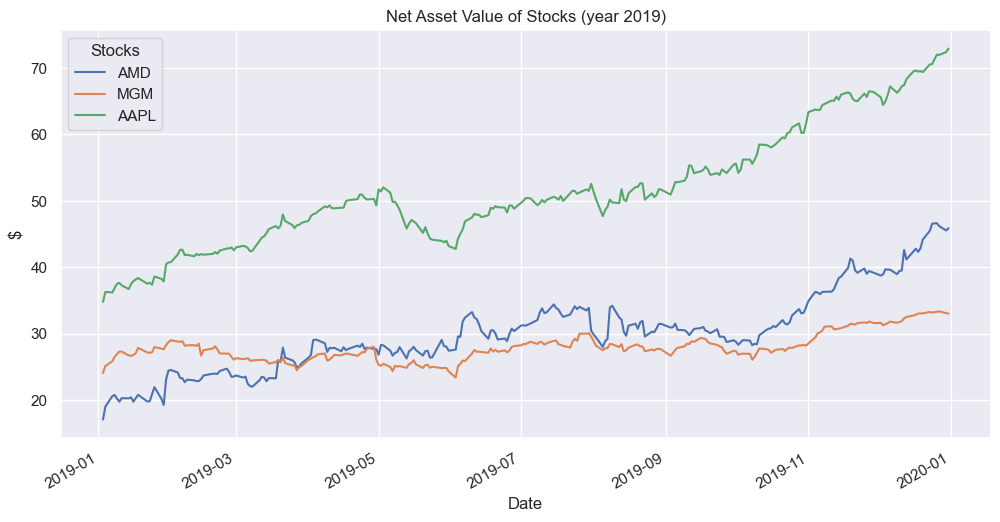

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))
NAV_2019.plot(ax=ax)
ax.set_title('Net Asset Value of Stocks (year 2019)')
ax.set_ylabel('$')
ax.legend(title="Stocks")
plt.show()

### Cumulative Profit and Loss (P&L)
The cumulative return, aka the cumulative profit and loss (PL), over a selected period, e.g. year 2019, is equivalent to the NAV normalized and subtracted of the initial investment

$$PL = \frac{NAV_t - NAV_0}{NAV_0}$$

In [51]:
PL_2019 = cumulative_returns_2019 - 1

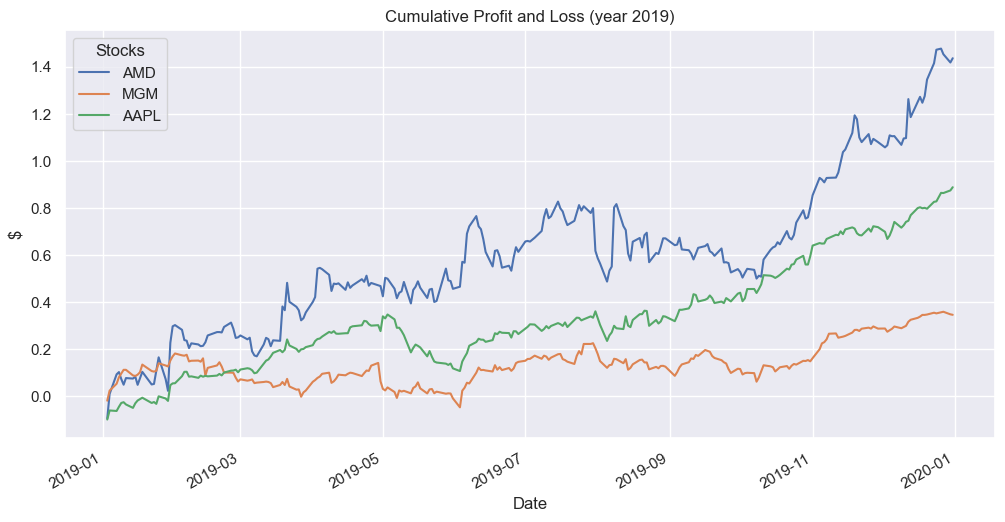

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))
PL_2019.plot(ax=ax)
ax.set_title('Cumulative Profit and Loss (year 2019)')
ax.set_ylabel('$')
ax.legend(title="Stocks")
plt.show()

### Volatility
The volatility is defined as the standard deviation of the portfolio returns (see p.156)

$$\sigma_p = \sqrt{w^T \Sigma w}$$

where $\Sigma$ is the covariance matrix of the portfolio returns and w is the normalized vector of the weights of the stocks in the portfolio

In [54]:
cov_matrix = stock_returns_2019.cov()
cov_matrix

,AMD,MGM,AAPL
AMD,0.001153,0.000278,0.000278
MGM,0.000278,0.000271,0.000130
AAPL,0.000278,0.000130,0.000272


In [55]:
volatility = np.sqrt(np.dot(np.transpose(w_norm), np.dot(cov_matrix.to_numpy(), w_norm)))
print('Portfolio volatility: {:.2f}'.format(volatility))

Portfolio volatility: 0.02


The annualized volatility $\sigma_p^A$ is defined as

$$\sigma_p^A = \sqrt{\gamma} \sigma_p = \sqrt{\gamma w^T \Sigma w}$$

In [57]:
volatility_annualized = np.sqrt(num_trading_days_2019) * volatility
print('Portfolio annualized volatility: {:.2f}'.format(volatility_annualized))

Portfolio annualized volatility: 0.27


### Sharpe Ratio
The Sharpe ratio (SR) is defined as the risk-adjusted expected excess return

$$SR = \frac{w^T \mu -r_f}{\sqrt{w^T \Sigma w}}$$

In other words, is the ration between the expected excess return compared to a risk-free asset rate $r_f$ and the portfolio volatility. Assuming $r_f = 0$

In [58]:
SR = exp_return_2019 / volatility
print('Sharpe ratio: {:.2f}'.format(SR))

Sharpe ratio: 0.16


### Annualized Sharpe Ratio

In [60]:
ASR = np.sqrt(num_trading_days_2019) * exp_return_2019 / volatility
print('Annualized Sharpe ratio: {:.2f}'.format(ASR))

Annualized Sharpe ratio: 2.49


### Value-at-Risk (VaR)
Based on [example by QuantaNews](https://www.pyquantnews.com/free-python-resources/risk-metrics-in-python-var-and-cvar-guide) 

In [63]:
confidence_level = 0.95
var = np.percentile(stock_returns_2019, (1 - confidence_level) * 100)
print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level is {var:.2%}")

Value at Risk (VaR) at 95.0% confidence level is -3.01%


### Conditional Value-at-Risk (CVaR)

In [69]:
var_threshold = np.percentile(stock_returns_2019, (1 - confidence_level) * 100)
tail_losses = stock_returns_2019[stock_returns_2019 < var_threshold]
#tail_losses

In [70]:
cvar = tail_losses.mean()
#print(f"Conditional Value at Risk (CVaR) at {confidence_level*100}% confidence level is {cvar:.2%}")

### Drawdown
The drawdown measures the decline from a historical peak, aka *high-water mark (HWM)*, of the cumulative profit or NAV
$$D_t = HWM_t - NAV_t$$

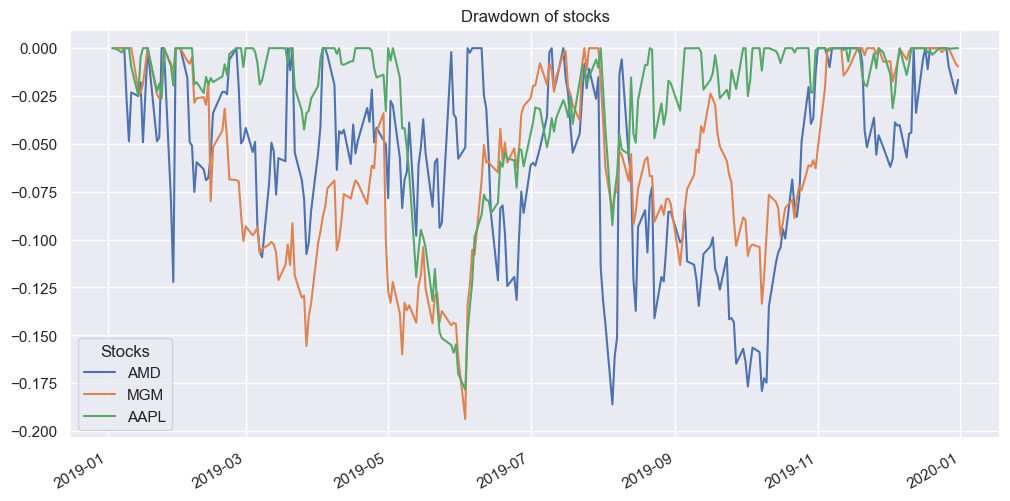

In [23]:
running_max = cumulative_returns_2019.cummax() # HWM
drawdowns = (cumulative_returns_2019 - running_max) / running_max
# Plot drawdowns
fig, ax = plt.subplots(figsize=(12, 6))
drawdowns.plot(ax=ax)
ax.set_title('Drawdown of stocks')
ax.set_xlabel(None)
ax.legend(title="Stocks")
plt.show()

## 3. Heuristic Portfolios
A portfolio is constructed using a mathematical optimization procedure to maximize the return and minimize the risk such as the mean-variance portfolio (MVP). Nevertheless traders have created many heuristic portfolios without using a numerical procedure. An examples of these portfolios is the equally weighted portfolio, aka 1/N portfolio.

In [29]:
def EWP(X):
    '''
    Equally weighted portfolio,
    aka 1/N portfolio
    '''
    N = X.shape[1]
    return np.repeat(1/N, N)

## 4. Naive Backtesting of the 1/N portfolio
By definition (see p.219) "a backtest evaluates the out-of-sample performance of an investment strategy using past observations". An investment strategy is composed of a portfolio, with an initial budget, that can be rebalanced according to some strategy rules. The backtest evaluation is perfomed using one or more performane measures. For the naive backtesting of the 1/N portfolio we assume daily rebalancing and no transaction cost. 

In [10]:
stock_prices = SP500_stocks_2015to2020[["AMD", "MGM", "AAPL", "AMZN", "TSCO"]].loc["2019-10":]
T, N = stock_prices.shape
print('Number of observations T={:d}\nNumber of stocks N={:d}'.format(T,N))

Number of observations T=247
Number of stocks N=5


We compute the linear returns from the daily prices
$$r_t = \frac{p_t}{p_{t-1}} - 1$$

In [12]:
X = stock_prices / stock_prices.shift(1) - 1
X = X.dropna()
X.tail()

,AMD,MGM,AAPL,AMZN,TSCO
Date,,,,,
2020-09-16,-0.028760,-0.030750,-0.029514,-0.024723,-0.018668
2020-09-17,-0.001435,-0.021295,-0.015964,-0.022537,-0.000723
2020-09-18,-0.021163,-0.022202,-0.031720,-0.017888,-0.000290
2020-09-21,0.040171,-0.042234,0.030326,0.001882,-0.004019
2020-09-22,-0.003079,0.025130,0.015716,0.056923,0.029479


We create an equally weighted, or 1/N, portfolio by setting the weights

In [30]:
w = EWP(X)
w

array([0.2, 0.2, 0.2, 0.2, 0.2])

We computes the portfolio returns from the weights and the stocks returns as defined above

$$R_t^{portf} = w^T r_t$$

In [27]:
portf_ret = X @ w
portf_ret.tail()

Date
2020-09-16   -0.026483
2020-09-17   -0.012391
2020-09-18   -0.018653
2020-09-21    0.005225
2020-09-22    0.024834
dtype: float64